In [1]:
plate_1 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate1.csv"
plate_1_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate1_repeat.csv"
plate_2_1 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_1.csv"
plate_2_2 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_2.csv"
plate_2_3 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_3.csv"
plate_2_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_repeat.csv"
plate_2_repeat_96 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate2_repeat _96.csv"
list_A = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listA.csv"
list_A_repeat = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listA_repeat.csv"
list_B = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB.csv"
list_B_repeat_end = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB_repeat _end.csv"
list_B_repeat_96 = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listB_repeat _96.csv"
list_C = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\listC.csv"

HsHis6_PEX5C_vs_HsPEX5C = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\Hs-His6-PEX5C vs HsPEX5C.csv"
HsPEX5C_Y467C_vs_AtPEX5C_WT = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\HsPEX5C Y467C vs AtPEX5C WT.csv"
F606C_vs_AtPEX5C_WT_1_hour = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\F606C vs AtPEX5C WT 1 hour.csv"

plate_map_file = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\plate_map.csv"
Hs_His6_PEX5C_vs_HsPEX5C_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\Hs-His6-PEX5C vs HsPEX5C platemap.csv"
HsPEX6C_Y467C_vs_AtPEX5C_WT_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\HsPEX6C Y467C vs AtPEX5C WT platemap.csv"
F606C_vs_AtPEX5C_WT_1_hour_platemap = "C:\\Users\\Bartek\\Documents\\Fluorescence-Anisotropy-Analysis\\tests\\Test data\\F606C vs AtPEX5C WT 1 hour platemap.csv"

In [41]:
import csv
import re
import string
import math
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from plate_mapping import plate_mapping as pm

# define custom errors
class DataError(Exception):
    pass

class PlateSizeError(Exception):
    pass

class DataTypeError(Exception):
    pass

# define well plate dimensions
plate_dim = {96:(8, 12), 384:(16, 24)}

# define header names
pm.header_names = {'Well ID': {'dtype':str, 'long':True, 'short_row': False, 'short_col':False},
                'Type': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Contents': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Protein Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Protein Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Tracer Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Tracer Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Competitor Name': {'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                'Competitor Concentration': {'dtype':float, 'long':True, 'short_row': True, 'short_col':True},
                'Concentration Units':{'dtype':str, 'long':True, 'short_row': True, 'short_col':True},
                }

class FA:
    """Class used for the analysis of fluorescence anisotropy data.
    
    :param data_dict: A dictionary contaning data frames with pre-processed data and metadata
    :type data_dict: dict
    :param g_factor: G-factor
    :type g_factor: float 
    :param plate_map: dataframe from a plate map csv file that defines each and every well
    :type plate_map: pandas dataframe
    """
    def __init__(self, data_dict, g_factor, plate_map):
        self.data_dict = data_dict
        self.g_factor = g_factor
        self.plate_map = plate_map
        
        # join all p and s data frame into one to run some stats
        frames = []

        for repeat in self.data_dict.values():   
            metadata, data = repeat.values()
            p_channel, s_channel = data.values()
            frames.append(p_channel)
            frames.append(s_channel)
    
        new = pd.concat(frames, axis=1)
        na = new.size - new.describe().loc['count'].sum()   # number of 'nan' cells
        
        print("Data has been uploaded\n")
        print(f"The value of g-factor is: {self.g_factor} \nThe number of repeats is: {len(self.data_dict)} \nThe number of empty cells is: {na}")
              
              
    @classmethod
    def read_in_envision(cls, data_csv, platemap_csv, data_type='plate', size=384):
        """Returns a dictionary of data frames, g-factor and platemap needed to construct the class object. 
        
        :param data_csv: File path of the raw data file in .csv format
        :type data_csv: str
        :param platemap_csv: File path of the platemap file in .csv format
        :type platemap_csv: str
        :param data_type: Format in which the raw data was exported (plate or list), defaults to plate
        :type data_type: str
        :param size: Size of the well plate (384 or 96), defaults to 384
        :type size: int
        :return: A dictionary contaning data frames with pre-processed data, g-factor, pandas data frame containing platemap
        :rtype: dict, float, pandas data frame """
        
        # ensure the plate size is either 384 or 96
        if size not in plate_dim:
            raise PlateSizeError('Invalid size of the well plate, should be 384 or 96.')
        
        # try to read in data in plate format
        if data_type == 'plate':
            try:
                data_dict, g_factor = FA._read_in_plate(data_csv, size=size)
                plate_map_df = pm.plate_map(platemap_csv, size=size)
                return cls(data_dict, g_factor, plate_map_df)
            
            except (UnboundLocalError, IndexError, ValueError):
                raise DataError(f"Error occured during data read in. Check your file contains data in the 'plate' format and plate size is {size}.")
        
        # try to read in data in list format
        if data_type == 'list':
            try:
                data_dict, g_factor = FA._read_in_list(data_csv, size=size)
                plate_map_df = pm.plate_map(platemap_csv, size=size)
                return cls(data_dict, g_factor, plate_map_df)
            
            except (UnboundLocalError, IndexError):
                raise DataError("Error occured during data read in. Check your file contains data in the 'list' format.")
        
        else:
            raise DataTypeError(f"'{data_type}' is not one of the two valid data types: plate or list.")
    

                
    def _read_in_plate(csv_file, size):
        """Reads the raw data file and finds the information needed to extract data. Passes those parameters to pre_process_plate function and executes it.
        Returns a tuple of two elemnts: dictionary of data frames and g-factor.

        :param csv_file: File path of the raw data file in .csv format
        :type csv_file: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A tuple of dictionary of data frames and the g-factor 
        :rtype: tuple """
        
        with open(csv_file) as file:
            all_data_lines = list(csv.reader(file, delimiter=','))   # read the csv file and cast it into a list containing all lines

        blank_indexes = list(index for index, item in enumerate(all_data_lines) if item == [] or set(item) == {''})   # list containing indices of all blank rows
        blanks = np.array(blank_indexes)   # convert the list of blank indices to a numpy array
        read_in_info = []   # list to store the tuples with parameters needed for pandas to read in the csv file

        for index, item in enumerate(all_data_lines):   # iterate over all lines in the csv file
            if item != [] and re.findall(r"Plate information", item[0]) == ['Plate information'] and re.search(r'Results for', all_data_lines[index + 9][0]) == None and re.findall(r"Formula", all_data_lines[index+1][10]) != ['Formula']:
                skiprows = index + 9   # Set the skiprows parameter for raw data table
                skiprows_meta = index + 1   # Set the skiprows parameter for metadata table
                end_of_data = blanks[blanks > skiprows].min()   # Calculate the end of data table by finding the smallest blank index after the beginning of data table
                read_in_info.append((skiprows, end_of_data - skiprows + 1, skiprows_meta))   # add the skiprows, caculated number of data lines and skiprows for metadata parameters to the list as a tuple
                data_format = 'plate1'

            if item != [] and re.findall(r"Plate information", item[0]) == ['Plate information'] and re.search(r'Results for', all_data_lines[index + 9][0]) != None:
                skiprows = index + 10
                skiprows_meta = index + 1
                end_of_data = blanks[blanks > skiprows].min()
                read_in_info.append((skiprows, end_of_data - skiprows - 1, skiprows_meta))
                data_format = 'plate2'

            if item != [] and len(item) > 1 and re.fullmatch(r"G-factor", item[0]):
                g_factor = float(item[4])   
        
        return FA._pre_process_plate(csv_file, read_in_info, data_format, size), g_factor

    
    def _pre_process_plate(csv_file, read_in_info, data_format, size):    
        """Extracts the data and metadata from the csv file, processes it and returns a nested dictionary containing data and metadata for each repeat and channel.

        :param csv_file: File path of the raw data file in .csv format
        :type csv_file: str
        :param read_in_info: Tuples with read in parameters for each channel.
        :type read_in_info: list
        :param data_format: Plate type (plate1 or plate2)
        :type data_format: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A dictionary containing data and metadata 
        :rtype: dict """ 
        
        data_frames = {}   # dictionary to store data frames
        counter = 1   # counter incremented by 0.5 to enable alternating labelling of data frames as 'p' or 's'

        row_letters = list(string.ascii_uppercase)[0: plate_dim[size][0]]   # generate a list of letters for well IDs
        col_numbers = list(np.arange(1, plate_dim[size][1] + 1).astype(str))   # generate a list of numbers for well IDs
        well_ids = ['%s%s' % (item[0], item[1]) for item in product(row_letters, col_numbers)]   # generate a list of well IDs for the pre-processed data frames
        
        for index, item in enumerate(read_in_info):   # iterate over all tuples in the list, each tuple contains skiprows, nrows and skiprows_meta for one channel 

            if data_format == 'plate1':   # raw data table does not have row and column names so 'names' parameter passed to omit the last column
                raw_data = pd.read_csv(csv_file, sep=',', names=col_numbers, index_col=False, engine='python', skiprows=item[0], nrows=item[1], encoding='utf-8')

            if data_format == 'plate2':   # raw data table has row and column names, so index_col=0 to set the first column as row labels
                raw_data = pd.read_csv(csv_file, sep=',', index_col=0, engine='python', skiprows=item[0], nrows=item[1], encoding='utf-8')
                if len(raw_data.columns) in [13, 25]:    
                    raw_data.drop(raw_data.columns[-1], axis=1, inplace=True)    # delete the last column because it is empty

            # generate df for metadata (number of rows of metadata table is always 1) and convert measurement time into datetime object   
            metadata = pd.read_csv(csv_file, sep=',', engine='python', skiprows=item[2], nrows=1, encoding='utf-8').astype({'Measurement date': 'datetime64[ns]'})
            # convert and reshape data frame into 1D array
            data_as_array = np.reshape(raw_data.to_numpy(), (int(size), 1)) 

            if counter % 1 == 0: 
                new_data = pd.DataFrame(data=data_as_array, index=well_ids, columns=['p'])   # generate new 384 (or 96) by 1 data frame with p channel data
                data_frames[f'repeat_{int(counter)}'] = {'metadata':metadata, 'data': {'p': new_data, 's':''}}   # add p channel data and metadata dfs to dictionary

            if counter % 1 != 0:
                new_data = pd.DataFrame(data=data_as_array, index=well_ids, columns=['s'])   # generate new 384 (or 96) by 1 data frame with s channel data
                data_frames[f'repeat_{int(counter-0.5)}']['data']['s'] = new_data   # add s channel data to dictionary

            counter = counter + 0.5
        
        return data_frames


    def _read_in_list(csv_file, size):
        """Reads the raw data file and extracts the data and metadata. Passes the raw data to pre_process_list function and executes it.
        Returns a tuple of two elemnts: dictionary of data frames and g-factor.

        :param csv_file: File path of the raw data file in .csv format
        :type csv_file: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A tuple of dictionary of data frames and the g-factor
        :rtype: tuple """

        with open(csv_file) as file:  
            all_data_lines = list(csv.reader(file, delimiter=',')) # read the csv file and cast it into a list containing all lines
 
        blank_indexes = list(index for index, item in enumerate(all_data_lines) if item == [] or set(item) == {''})   # list containing indexes of all blank rows
        blanks = np.array(blank_indexes)   # convert the list of blank indexes to a numpy array
        
        # iterate over all lines to find beggining of the data table ('skiprows') and determine the format of data  (list A, B, or C)
        for index, item in enumerate(all_data_lines):   
            if item != [] and len(item) == 1 and re.findall(r"Plate information", item[0]) == ["Plate information"]:
                skiprows_meta = index + 1
                end_of_metadata = blanks[blanks > skiprows_meta].min()   # find the end of metadata by finding the smallest blank index after the beginning of metadata
                
            if item != [] and len(item) >= 2 and re.findall(r"PlateNumber", item[0]) == ['PlateNumber'] and re.findall(r"PlateRepeat", item[1]) == ['PlateRepeat']:   # find line number with the beggining of the data
                skiprows = index - 1
                data_format = 'listA'
                end_of_data = blanks[blanks > skiprows].min()

            if item != [] and len(item) >= 2 and re.findall(r"Plate", item[0]) == ['Plate'] and re.findall(r"Barcode", item[1]) == ['Barcode']:   # find line number with the beggining of the data
                skiprows = index
                data_format = 'listB'
                end_of_data = blanks[blanks > skiprows].min()

            if item != [] and len(item) >= 2 and re.findall(r"Plate", item[0]) == ['Plate']  and re.findall(r"Well", item[1]) == ['Well']:
                skiprows = index
                data_format = 'listC'
                end_of_data = blanks[blanks > skiprows].min()

            if item != [] and re.fullmatch(r"G-factor", item[0]):   # find the g factor
                g_factor = float(item[4])

        nrows = end_of_data - skiprows - 1   # calculate the length of data table
        nrows_meta = end_of_metadata - skiprows_meta - 1   # calucalte the length of metadata table (number of rows depends on the number of repeats)

        raw_data = pd.read_csv(csv_file, sep=',', engine='python', skiprows=skiprows, nrows=nrows, encoding='utf-8')
        raw_metadata = pd.read_csv(csv_file, sep=',', engine='python', skiprows=skiprows_meta, nrows=nrows_meta, encoding='utf-8')

        return FA._pre_process_list(raw_data, raw_metadata, data_format, size), g_factor


    def _pre_process_list(raw_data, raw_metadata, data_format, size):
        """Extracts the data and metadata for each channel and repeat from the raw data and raw metadata 
        and returns a nested dictionary containing data and metadata for each repeat and channel.

        :param raw_data: Data frame containing raw data
        :type raw_data: pandas data frame
        :param raw_metadata: Data frame containing raw metadata
        :type raw_metadata: pandas data frame
        :param data_format: Type of list (listA, listB, or listC)
        :type data_format: str
        :param well_ids: A list of well IDs for the pre-processed data frames
        :type well_ids: list
        :return: A dictionary containing data and metadata
        :rtype: dict"""

        # remove the '0' from middle position of well numbers (A01 -> A1), done by reassigning the 'Well' column to a Series containing modified well numbers
        raw_data['Well'] = raw_data['Well'].apply(lambda x: x[0] + x[2] if x[1] == '0' else x)
        
        data_frames = {}   # dictionary to store data frames
        repeats = list(raw_metadata['Repeat'].to_numpy())   # generate a list with repeats based on the metadata table, e.g. for 3 repeats -> [1,2,3]

        row_letters = list(string.ascii_uppercase)[0: plate_dim[size][0]]   # generate a list of letters for well IDs
        col_numbers = list(np.arange(1, plate_dim[size][1] + 1).astype(str))   # generate a list of numbers for well IDs
        well_ids = ['%s%s' % (item[0], item[1]) for item in product(row_letters, col_numbers)]   # generate a list of well IDs for the pre-processed data frames
        
        for index, repeat in enumerate(repeats):   # iterate over the number of repeats
            if data_format == 'listA':
                groupped_data = raw_data.groupby(raw_data.PlateRepeat).get_group(repeat)   # group and extract the data by the plate repeat column, i.e. in each iteration get data only for the current repeat 

                p_groupped = groupped_data.iloc[::3, :]   # extract data only for the p channel, i.e. each third row starting from the first row
                s_groupped = groupped_data.iloc[1::3, :]   # extract data only for the s channel, i.e. each third row starting from the second row

                p_raw_data = p_groupped[['Well', 'Signal']]   # extract only the two relevant columns
                s_raw_data = s_groupped[['Well', 'Signal']]   # for each channel

            if data_format in ['listB', 'listC']: 
                # the column naming is different for the first repeat ('Signal'), then it's 'Signal.1', 'Signal.2', etc.
                if repeat == 1: 
                    p_raw_data = raw_data[['Well', 'Signal']]   
                    s_raw_data = raw_data[['Well', f'Signal.{repeat}']]
                else:
                    p_raw_data = raw_data[['Well', f'Signal.{repeat + index - 1}']]   # the column cotntaining data to be extracted is calculated in each iteration
                    s_raw_data = raw_data[['Well', f'Signal.{repeat + index}']]
            
            # create an empty df with no columns and indexes matching the plate size
            indexes = pd.DataFrame(well_ids, columns=['Wells'])
            empty_frame = indexes.set_index('Wells')
            
            p_raw_data.set_index('Well', inplace=True)   # set the row indexes as the well numbers
            p_raw_data.set_axis(['p'], axis=1, inplace=True)   # rename the 'Signal' column to 'p'
            p_data = empty_frame.join(p_raw_data)   # join the raw data df to an empty frame based on the indexes, assigns 'NaN' to indexes not present in the raw data table
            
            s_raw_data.set_index('Well', inplace=True) 
            s_raw_data.set_axis(['s'], axis=1, inplace=True)
            s_data = empty_frame.join(s_raw_data)
    
            metadata = raw_metadata.iloc[[repeat-1]].astype({'Measurement date': 'datetime64[ns]'})   # extract the row with metadata relevant for each repeat and covert date and time into a datetime object
            data_frames[f'repeat_{repeat}'] = {'metadata': metadata, 'data': {'p': p_data, 's': s_data}}   # add data frames to the dictionary

        return data_frames
    
    
    def visualise(self, colorby='Type', labelby='Type', title="", cmap='Paired', dpi=250, export=False):
        """Returns a visual representation of the plate map.
        The label and colour for each well can be customised to be a variable, for example 'Type', 'Protein Name', 'Protein Concentration', etc.
        It can also be the p or s anisotropy value from a specified repeat passed as a tuple of strings, for example ('repeat_2', 'p') for p data from repeat 2
        
        :param colorby: Chooses the parameter to color code by, for example 'Type', 'Contents', 'Protein Concentration', ('repeat_2', 'p'), default = 'Type'
        :type colorby: str or tuple
        :param labelby: Chooses the parameter to label code by, for example 'Type', 'Contents', 'Protein', ('repeat_1', 's'), default = 'Type'
        :type labelby: str or tuple
        :param title: Sets the title of the figure, default none
        :type title: str
        :param cmap: Sets the colormap for the color-coding, default = 'Paired'
        :type cmap: str
        :param dpi: Size of the figure, default = 300
        :type dpi: int
        :param export: If 'True' a .png file of the figure is saved, default = False
        :type export: bool
        :return: Visual representation of the plate map.
        :rtype: figure
        """
        plate_map = self.plate_map
        
        if type(labelby) == tuple:   # option for labelling by the p or s anisotropy values
            plate_map = self.plate_map.join(self.data_dict[labelby[0]]['data'][labelby[1]])   # data frame containing p or s values from specified repeat is added to the platemap
            labelby = labelby[1]
        if type(colorby) == tuple:   # option for colouring by the p or s anisotropy values
            plate_map =  self.plate_map.join(self.data_dict[colorby[0]]['data'][colorby[1]])
            colorby = colorby[1]
            
        size = plate_map.shape[0]
        
        return pm.visualise(platemap=plate_map, title=title, size=size, export=export, cmap=cmap, colorby=colorby, labelby=labelby, dpi=dpi)
    
    
    def invalidate(self, valid=False, **kwargs):
        """Invalidates wells, columns or rows. Any of the following arguments or their combination can be passed: wells, rows, columns. 
        For example to invalidate well A1, rows C and D and columns 7 and 8 execute: invalidate(wells='A1', rows=['C','D'], columns=[7,8])
    
        :param valid: Sets the stipulated row or rows 'True' or 'False', default = False
        :type valid: bool
        :param wells: Wells to be invalidated passed as a string or a list of strings
        :type wells: str or list
        :param rows: Rows to be invalidated passed as a string or a list of strings
        :type rows: str or list
        :param columns: Columns to be invalidated passed as an integer or a list of integers
        :type columns: int or list
        """
        # execute the corresponding invalidate functon from the platemapping package
        if 'wells' in kwargs:
            pm.invalidate_wells(platemap=self.plate_map, wells=kwargs['wells'], valid=valid)
        if 'rows' in kwargs:
            rows = tuple(kwargs['rows']) # convert the rows to tuple because invalidaet_rows cannot take in a list
            pm.invalidate_rows(platemap=self.plate_map, rows=rows, valid=valid)
        if 'columns' in kwargs:
            pm.invalidate_cols(platemap=self.plate_map, cols=kwargs['columns'], valid=valid)
        if len(kwargs) == 0:   # return error if neither of the keyword arguments is passed
            raise TypeError('No arguments were passed. Specify the wells, rows or columns to be invalidated!')
            
            
            
    def background_correct(self):
        
        for key, value in self.data_dict.items(): 
            metadata, data = value.values()   
            p, s = data.values()             
            p_df = self.plate_map.join(p)  
            s_df = self.plate_map.join(s)
            
            self.data_dict[key]['data']['p_corrected'] = FA._backg_correct(p_df)   
            self.data_dict[key]['data']['s_corrected'] = FA._backg_correct(s_df)
            
            
    def _backg_correct(df):
        
        df[df.columns[-1]] = df[df.columns[-1]][df['Valid'] == True]   # 'p' or 's' values are replaced with NaN if the well is invalidated
        no_index = df.reset_index()   # move the index to df column

        mindex = pd.MultiIndex.from_frame(no_index[['Type', 'Protein Name', 'Protein Concentration']])   # create multiindex
        reindexed = no_index.set_index(mindex).drop(['Type', 'Protein Name', 'Protein Concentration'], axis=1)   # add multiindex to df and drop the columns from which multiindex was created

        mean = reindexed.groupby(level=[0,1,2]).mean().drop('Valid', axis=1)   # calculate mean for each group of three wells and remove 'Valid' column
        mean.rename(columns={mean.columns[-1]: 'Mean'}, inplace=True)   # rename the last column to 'Mean'

        blank = mean.xs('blank', level=0, drop_level=True)   # take a group with blank wells
        
        joined = reindexed.join(blank, on=['Protein Name', 'Protein Concentration'])
        joined['Corrected'] = joined[joined.columns[-2]] - joined['Mean']   # calculate background corrected values
        jindexed = joined.set_index('index', append=True).reset_index(level=[0,1,2])   # set index to 'well id' and move multiindex to df columns

        return jindexed[['Corrected']]

In [42]:
my_data1 = FA.read_in_envision(data_csv=HsHis6_PEX5C_vs_HsPEX5C, platemap_csv=Hs_His6_PEX5C_vs_HsPEX5C_platemap, data_type='plate', size=384)

Data has been uploaded

The value of g-factor is: 1.0 
The number of repeats is: 1 
The number of empty cells is: 192.0


In [ ]:
my_data1.invalidate(wells=['A1', 'D2', 'E2', 'F2'])

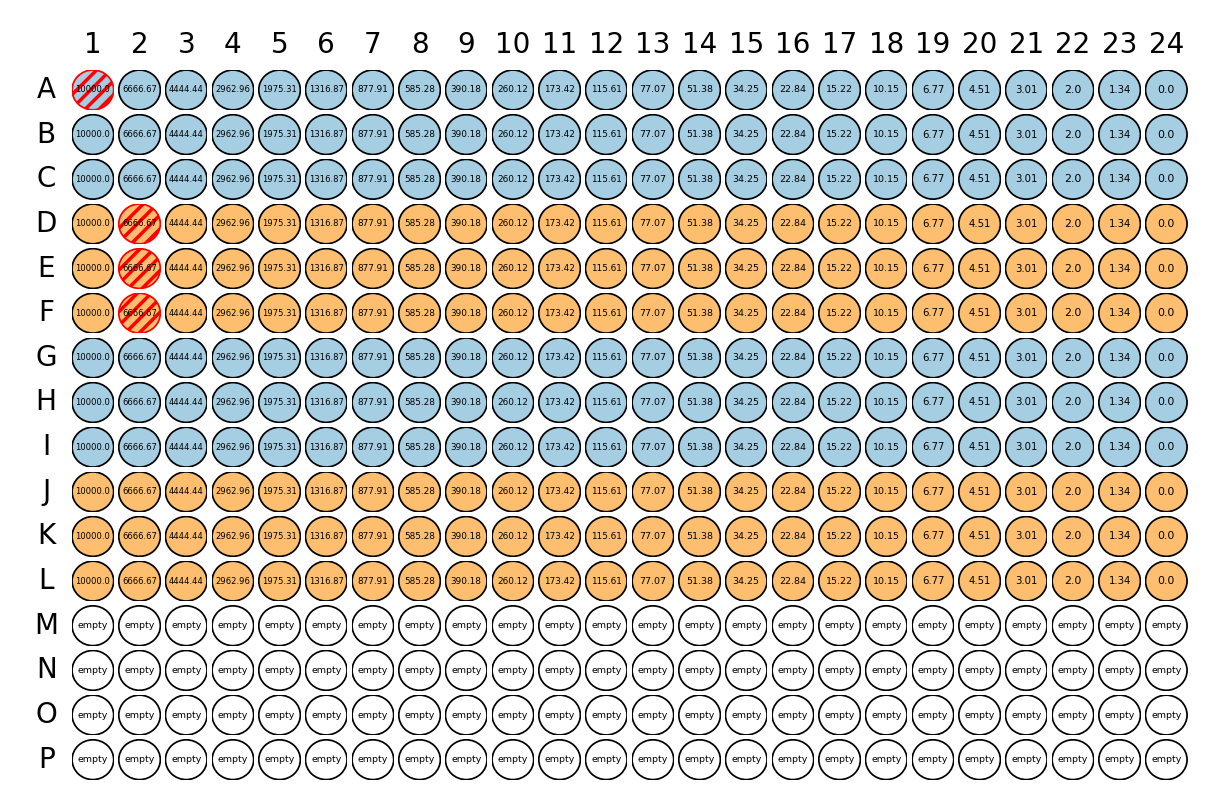

In [44]:
my_data1.visualise(labelby='Protein Concentration', colorby='Type', export='C:\\Users\\Bartek\\Desktop\\plt.png')

In [45]:
my_data1.background_correct()

In [46]:
my_data1.data_dict['repeat_1']['data']['p_corrected']

,Corrected
index,
A1,NaN
A2,NaN
A3,108688.000000
A4,112349.000000
A5,126901.666667
...,...
P20,NaN
P21,NaN
P22,NaN


In [49]:
my_data1.data_dict['repeat_1']['data']['s_corrected'].iloc[0:60]

,Corrected
index,
A1,NaN
A2,NaN
A3,194545.666667
A4,179746.333333
A5,189597.666667
A6,187222.666667
A7,197629.333333
A8,196668.000000
A9,206505.666667


In [5]:
df = my_data1.plate_map.join(my_data1.data_dict['repeat_1']['data']['p'])

In [6]:
df

,Type,Contents,Protein Name,Protein Concentration,Tracer Name,Tracer Concentration,Competitor Name,Competitor Concentration,Concentration Units,Valid,p
A1,compound,NaN,Hs-His6-PEX5C,10000,Lissamine-YQSKL,200,NaN,NaN,nM,True,137450.0
A2,compound,NaN,Hs-His6-PEX5C,6666.67,Lissamine-YQSKL,200,NaN,NaN,nM,True,102467.0
A3,compound,NaN,Hs-His6-PEX5C,4444.44,Lissamine-YQSKL,200,NaN,NaN,nM,True,155187.0
A4,compound,NaN,Hs-His6-PEX5C,2962.96,Lissamine-YQSKL,200,NaN,NaN,nM,True,148702.0
A5,compound,NaN,Hs-His6-PEX5C,1975.31,Lissamine-YQSKL,200,NaN,NaN,nM,True,161974.0
...,...,...,...,...,...,...,...,...,...,...,...
P20,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
P21,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
P22,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
P23,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN


In [7]:
no_index = df.reset_index().rename(columns={'index': 'well ID'})
#no_index.rename(columns={'index': 'well ID'}, inplace=True)

In [8]:
no_index

,well ID,Type,Contents,Protein Name,Protein Concentration,Tracer Name,Tracer Concentration,Competitor Name,Competitor Concentration,Concentration Units,Valid,p
0,A1,compound,NaN,Hs-His6-PEX5C,10000,Lissamine-YQSKL,200,NaN,NaN,nM,True,137450.0
1,A2,compound,NaN,Hs-His6-PEX5C,6666.67,Lissamine-YQSKL,200,NaN,NaN,nM,True,102467.0
2,A3,compound,NaN,Hs-His6-PEX5C,4444.44,Lissamine-YQSKL,200,NaN,NaN,nM,True,155187.0
3,A4,compound,NaN,Hs-His6-PEX5C,2962.96,Lissamine-YQSKL,200,NaN,NaN,nM,True,148702.0
4,A5,compound,NaN,Hs-His6-PEX5C,1975.31,Lissamine-YQSKL,200,NaN,NaN,nM,True,161974.0
...,...,...,...,...,...,...,...,...,...,...,...,...
379,P20,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
380,P21,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
381,P22,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
382,P23,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN


In [9]:
mindex = pd.MultiIndex.from_frame(no_index[['Type', 'Protein Name', 'Protein Concentration']])

In [10]:
reindexed = no_index.set_index(mindex).drop(['Type', 'Protein Name', 'Protein Concentration'], axis=1)

In [11]:
reindexed

well ID Contents  \
Type     Protein Name  Protein Concentration                    
compound Hs-His6-PEX5C 10000.00                   A1      NaN   
                       6666.67                    A2      NaN   
                       4444.44                    A3      NaN   
                       2962.96                    A4      NaN   
                       1975.31                    A5      NaN   
...                                              ...      ...   
empty    NaN           NaN                       P20      NaN   
                       NaN                       P21      NaN   
                       NaN                       P22      NaN   
                       NaN                       P23      NaN   
                       NaN                       P24      NaN   

                                                  Tracer Name  \
Type     Protein Name  Protein Concentration                    
compound Hs-His6-PEX5C 10000.00               Lissamine-YQSKL   
                       6666.67                Lissamine-YQSKL   
                       4444.44                Lissamine-YQSKL   
                       2962.96                Lissamine-YQSKL   
                       1975.31                Lissamine-YQSKL   
...                                                       ...   
empty    NaN           NaN                                NaN   
                       NaN                                NaN   
                       NaN                                NaN   
                       NaN                                NaN   
                       NaN                                NaN   

                                             Tracer Concentration  \
Type     Protein Name  Protein Concentration                        
compound Hs-His6-PEX5C 10000.00                               200   
                       6666.67                                200   
                       4444.44                                200   
                       2962.96                                200   
                       1975.31                                200   
...                                                           ...   
empty    NaN           NaN                                    NaN   
                       NaN                                    NaN   
                       NaN                                    NaN   
                       NaN                                    NaN   
                       NaN                                    NaN   

                                             Competitor Name  \
Type     Protein Name  Protein Concentration                   
compound Hs-His6-PEX5C 10000.00                          NaN   
                       6666.67                           NaN   
                       4444.44                           NaN   
                       2962.96                           NaN   
                       1975.31                           NaN   
...                                                      ...   
empty    NaN           NaN                               NaN   
                       NaN                               NaN   
                       NaN                               NaN   
                       NaN                               NaN   
                       NaN                               NaN   

                                             Competitor Concentration  \
Type     Protein Name  Protein Concentration                            
compound Hs-His6-PEX5C 10000.00                                   NaN   
                       6666.67                                    NaN   
                       4444.44                                    NaN   
                       2962.96                                    NaN   
                       1975.31                                    NaN   
...                                                               ...   
empty    NaN           NaN            

In [11]:
#reindexed_d= reindexed.drop(['Type', 'Protein Name', 'Protein Concentration'], axis=1)

In [12]:
#reindexed_d

well ID Contents  \
Type     Protein Name  Protein Concentration                    
compound Hs-His6-PEX5C 10000.00                   A1      NaN   
                       6666.67                    A2      NaN   
                       4444.44                    A3      NaN   
                       2962.96                    A4      NaN   
                       1975.31                    A5      NaN   
...                                              ...      ...   
empty    NaN           NaN                       P20      NaN   
                       NaN                       P21      NaN   
                       NaN                       P22      NaN   
                       NaN                       P23      NaN   
                       NaN                       P24      NaN   

                                                  Tracer Name  \
Type     Protein Name  Protein Concentration                    
compound Hs-His6-PEX5C 10000.00               Lissamine-YQSKL   
                       6666.67                Lissamine-YQSKL   
                       4444.44                Lissamine-YQSKL   
                       2962.96                Lissamine-YQSKL   
                       1975.31                Lissamine-YQSKL   
...                                                       ...   
empty    NaN           NaN                                NaN   
                       NaN                                NaN   
                       NaN                                NaN   
                       NaN                                NaN   
                       NaN                                NaN   

                                             Tracer Concentration  \
Type     Protein Name  Protein Concentration                        
compound Hs-His6-PEX5C 10000.00                               200   
                       6666.67                                200   
                       4444.44                                200   
                       2962.96                                200   
                       1975.31                                200   
...                                                           ...   
empty    NaN           NaN                                    NaN   
                       NaN                                    NaN   
                       NaN                                    NaN   
                       NaN                                    NaN   
                       NaN                                    NaN   

                                             Competitor Name  \
Type     Protein Name  Protein Concentration                   
compound Hs-His6-PEX5C 10000.00                          NaN   
                       6666.67                           NaN   
                       4444.44                           NaN   
                       2962.96                           NaN   
                       1975.31                           NaN   
...                                                      ...   
empty    NaN           NaN                               NaN   
                       NaN                               NaN   
                       NaN                               NaN   
                       NaN                               NaN   
                       NaN                               NaN   

                                             Competitor Concentration  \
Type     Protein Name  Protein Concentration                            
compound Hs-His6-PEX5C 10000.00                                   NaN   
                       6666.67                                    NaN   
                       4444.44                                    NaN   
                       2962.96                                    NaN   
                       1975.31                                    NaN   
...                                                               ...   
empty    NaN           NaN            

In [13]:
#ordered = reindexed_d.reorder_levels([1,2,3,0])

In [14]:
#reindexed_d['p'] = pd.to_numeric(ordered['p'])

In [103]:
mean = reindexed.groupby(level=[0,1,2]).mean().drop('Valid', axis=1)#, inplace=True)

In [104]:
mean.rename(columns={mean.columns[-1]: 'Mean'}, inplace=True)

In [105]:
mean

Mean
Type     Protein Name  Protein Concentration               
blank    Hs-His6-PEX5C 0.00                    36372.666667
                       1.34                    34446.666667
                       2.00                    35290.333333
                       3.01                    33581.333333
                       4.51                    34132.666667
...                                                     ...
compound HsPEX5C       1975.31                129916.333333
                       2962.96                109235.333333
                       4444.44                102693.666667
                       6666.67                 97946.333333
                       10000.00               103016.666667

[96 rows x 1 columns]

In [14]:
#mean.drop('Valid', axis=1, inplace=True)

In [16]:
#mean.rename(columns={'p': 'mean'}, inplace=True)

In [15]:
b = mean.xs('blank', level=0, drop_level=True) #drop level must be true otherwise value error in join method that leng of lef must equal the right

In [16]:
b

Mean
Protein Name  Protein Concentration              
Hs-His6-PEX5C 0.00                   36372.666667
              1.34                   34446.666667
              2.00                   35290.333333
              3.01                   33581.333333
              4.51                   34132.666667
              6.77                   33671.333333
              10.15                  32758.666667
              15.22                  34969.000000
              22.84                  30528.000000
              34.25                  37429.333333
              51.38                  32885.000000
              77.07                  32855.333333
              115.61                 32702.333333
              173.42                 32425.000000
              260.12                 32958.666667
              390.18                 35883.666667
              585.28                 37887.000000
              877.91                 36228.000000
              1316.87                35770.666667
              1975.31                35072.333333
              2962.96                36353.000000
              4444.44                46499.000000
              6666.67                38179.666667
              10000.00               36079.666667
HsPEX5C       0.00                   36855.333333
              1.34                   34332.666667
              2.00                   35892.000000
              3.01                   34051.000000
              4.51                   33495.333333
              6.77                   32576.666667
              10.15                  32735.333333
              15.22                  35737.666667
              22.84                  35000.333333
              34.25                  33242.000000
              51.38                  32027.333333
              77.07                  32164.666667
              115.61                 40377.666667
              173.42                 32771.333333
              260.12                 32214.000000
              390.18                 32052.000000
              585.28                 33922.333333
              877.91                 32775.666667
              1316.87                37044.333333
              1975.31                33266.000000
              2962.96                34552.000000
              4444.44                36437.000000
              6666.67                36589.666667
              10000.00               35161.666667

In [27]:
c = reindexed.xs('compound', level=0, drop_level=False)

In [28]:
c

well ID Contents  \
Type     Protein Name  Protein Concentration                    
compound Hs-His6-PEX5C 10000.00                   A1      NaN   
                       6666.67                    A2      NaN   
                       4444.44                    A3      NaN   
                       2962.96                    A4      NaN   
                       1975.31                    A5      NaN   
...                                              ...      ...   
         HsPEX5C       4.51                      I20      NaN   
                       3.01                      I21      NaN   
                       2.00                      I22      NaN   
                       1.34                      I23      NaN   
                       0.00                      I24      NaN   

                                                  Tracer Name  \
Type     Protein Name  Protein Concentration                    
compound Hs-His6-PEX5C 10000.00               Lissamine-YQSKL   
                       6666.67                Lissamine-YQSKL   
                       4444.44                Lissamine-YQSKL   
                       2962.96                Lissamine-YQSKL   
                       1975.31                Lissamine-YQSKL   
...                                                       ...   
         HsPEX5C       4.51                   Lissamine-YQSKL   
                       3.01                   Lissamine-YQSKL   
                       2.00                   Lissamine-YQSKL   
                       1.34                   Lissamine-YQSKL   
                       0.00                   Lissamine-YQSKL   

                                             Tracer Concentration  \
Type     Protein Name  Protein Concentration                        
compound Hs-His6-PEX5C 10000.00                               200   
                       6666.67                                200   
                       4444.44                                200   
                       2962.96                                200   
                       1975.31                                200   
...                                                           ...   
         HsPEX5C       4.51                                   200   
                       3.01                                   200   
                       2.00                                   200   
                       1.34                                   200   
                       0.00                                   200   

                                             Competitor Name  \
Type     Protein Name  Protein Concentration                   
compound Hs-His6-PEX5C 10000.00                          NaN   
                       6666.67                           NaN   
                       4444.44                           NaN   
                       2962.96                           NaN   
                       1975.31                           NaN   
...                                                      ...   
         HsPEX5C       4.51                              NaN   
                       3.01                              NaN   
                       2.00                              NaN   
                       1.34                              NaN   
                       0.00                              NaN   

                                             Competitor Concentration  \
Type     Protein Name  Protein Concentration                            
compound Hs-His6-PEX5C 10000.00                                   NaN   
                       6666.67                                    NaN   
                       4444.44                                    NaN   
                       2962.96                                    NaN   
                       1975.31                                    NaN   
...                                                               ...   
         HsPEX5C       4.51           

In [79]:
j = c.join(b, on=['Protein Name', 'Protein Concentration'])

In [80]:
j

well ID Contents  \
Type     Protein Name  Protein Concentration                    
compound Hs-His6-PEX5C 10000.00                   A1      NaN   
                       6666.67                    A2      NaN   
                       4444.44                    A3      NaN   
                       2962.96                    A4      NaN   
                       1975.31                    A5      NaN   
...                                              ...      ...   
         HsPEX5C       4.51                      I20      NaN   
                       3.01                      I21      NaN   
                       2.00                      I22      NaN   
                       1.34                      I23      NaN   
                       0.00                      I24      NaN   

                                                  Tracer Name  \
Type     Protein Name  Protein Concentration                    
compound Hs-His6-PEX5C 10000.00               Lissamine-YQSKL   
                       6666.67                Lissamine-YQSKL   
                       4444.44                Lissamine-YQSKL   
                       2962.96                Lissamine-YQSKL   
                       1975.31                Lissamine-YQSKL   
...                                                       ...   
         HsPEX5C       4.51                   Lissamine-YQSKL   
                       3.01                   Lissamine-YQSKL   
                       2.00                   Lissamine-YQSKL   
                       1.34                   Lissamine-YQSKL   
                       0.00                   Lissamine-YQSKL   

                                             Tracer Concentration  \
Type     Protein Name  Protein Concentration                        
compound Hs-His6-PEX5C 10000.00                               200   
                       6666.67                                200   
                       4444.44                                200   
                       2962.96                                200   
                       1975.31                                200   
...                                                           ...   
         HsPEX5C       4.51                                   200   
                       3.01                                   200   
                       2.00                                   200   
                       1.34                                   200   
                       0.00                                   200   

                                             Competitor Name  \
Type     Protein Name  Protein Concentration                   
compound Hs-His6-PEX5C 10000.00                          NaN   
                       6666.67                           NaN   
                       4444.44                           NaN   
                       2962.96                           NaN   
                       1975.31                           NaN   
...                                                      ...   
         HsPEX5C       4.51                              NaN   
                       3.01                              NaN   
                       2.00                              NaN   
                       1.34                              NaN   
                       0.00                              NaN   

                                             Competitor Concentration  \
Type     Protein Name  Protein Concentration                            
compound Hs-His6-PEX5C 10000.00                                   NaN   
                       6666.67                                    NaN   
                       4444.44                                    NaN   
                       2962.96                                    NaN   
                       1975.31                                    NaN   
...                                                               ...   
         HsPEX5C       4.51           

In [81]:
j['Corrected'] = j[j.columns[-2]] - j['Mean'] #j['Corrected'] = j['p'] - j['Mean']

In [82]:
j

well ID Contents  \
Type     Protein Name  Protein Concentration                    
compound Hs-His6-PEX5C 10000.00                   A1      NaN   
                       6666.67                    A2      NaN   
                       4444.44                    A3      NaN   
                       2962.96                    A4      NaN   
                       1975.31                    A5      NaN   
...                                              ...      ...   
         HsPEX5C       4.51                      I20      NaN   
                       3.01                      I21      NaN   
                       2.00                      I22      NaN   
                       1.34                      I23      NaN   
                       0.00                      I24      NaN   

                                                  Tracer Name  \
Type     Protein Name  Protein Concentration                    
compound Hs-His6-PEX5C 10000.00               Lissamine-YQSKL   
                       6666.67                Lissamine-YQSKL   
                       4444.44                Lissamine-YQSKL   
                       2962.96                Lissamine-YQSKL   
                       1975.31                Lissamine-YQSKL   
...                                                       ...   
         HsPEX5C       4.51                   Lissamine-YQSKL   
                       3.01                   Lissamine-YQSKL   
                       2.00                   Lissamine-YQSKL   
                       1.34                   Lissamine-YQSKL   
                       0.00                   Lissamine-YQSKL   

                                             Tracer Concentration  \
Type     Protein Name  Protein Concentration                        
compound Hs-His6-PEX5C 10000.00                               200   
                       6666.67                                200   
                       4444.44                                200   
                       2962.96                                200   
                       1975.31                                200   
...                                                           ...   
         HsPEX5C       4.51                                   200   
                       3.01                                   200   
                       2.00                                   200   
                       1.34                                   200   
                       0.00                                   200   

                                             Competitor Name  \
Type     Protein Name  Protein Concentration                   
compound Hs-His6-PEX5C 10000.00                          NaN   
                       6666.67                           NaN   
                       4444.44                           NaN   
                       2962.96                           NaN   
                       1975.31                           NaN   
...                                                      ...   
         HsPEX5C       4.51                              NaN   
                       3.01                              NaN   
                       2.00                              NaN   
                       1.34                              NaN   
                       0.00                              NaN   

                                             Competitor Concentration  \
Type     Protein Name  Protein Concentration                            
compound Hs-His6-PEX5C 10000.00                                   NaN   
                       6666.67                                    NaN   
                       4444.44                                    NaN   
                       2962.96                                    NaN   
                       1975.31                                    NaN   
...                                                               ...   
         HsPEX5C       4.51           

In [33]:
jindexed = j.set_index('well ID', append=True).reset_index(level=[0,1,2], inplace=False)

In [25]:
#jreindexed = jindexed.reset_index(level=[0,1,2], inplace=False)

In [34]:
jindexed

,Type,Protein Name,Protein Concentration,Contents,Tracer Name,Tracer Concentration,Competitor Name,Competitor Concentration,Concentration Units,Valid,p,Mean,Corrected
well ID,,,,,,,,,,,,,
A1,compound,Hs-His6-PEX5C,10000.00,NaN,Lissamine-YQSKL,200,NaN,NaN,nM,True,137450.0,36079.666667,101370.333333
A2,compound,Hs-His6-PEX5C,6666.67,NaN,Lissamine-YQSKL,200,NaN,NaN,nM,True,102467.0,38179.666667,64287.333333
A3,compound,Hs-His6-PEX5C,4444.44,NaN,Lissamine-YQSKL,200,NaN,NaN,nM,True,155187.0,46499.000000,108688.000000
A4,compound,Hs-His6-PEX5C,2962.96,NaN,Lissamine-YQSKL,200,NaN,NaN,nM,True,148702.0,36353.000000,112349.000000
A5,compound,Hs-His6-PEX5C,1975.31,NaN,Lissamine-YQSKL,200,NaN,NaN,nM,True,161974.0,35072.333333,126901.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
I20,compound,HsPEX5C,4.51,NaN,Lissamine-YQSKL,200,NaN,NaN,nM,True,240426.0,33495.333333,206930.666667
I21,compound,HsPEX5C,3.01,NaN,Lissamine-YQSKL,200,NaN,NaN,nM,True,258414.0,34051.000000,224363.000000
I22,compound,HsPEX5C,2.00,NaN,Lissamine-YQSKL,200,NaN,NaN,nM,True,239727.0,35892.000000,203835.000000


In [27]:
needed = jindexed['Corrected']

In [35]:
result = df.join(jindexed['Corrected'])

In [36]:
result

,Type,Contents,Protein Name,Protein Concentration,Tracer Name,Tracer Concentration,Competitor Name,Competitor Concentration,Concentration Units,Valid,p,Corrected
A1,compound,NaN,Hs-His6-PEX5C,10000,Lissamine-YQSKL,200,NaN,NaN,nM,True,137450.0,101370.333333
A2,compound,NaN,Hs-His6-PEX5C,6666.67,Lissamine-YQSKL,200,NaN,NaN,nM,True,102467.0,64287.333333
A3,compound,NaN,Hs-His6-PEX5C,4444.44,Lissamine-YQSKL,200,NaN,NaN,nM,True,155187.0,108688.000000
A4,compound,NaN,Hs-His6-PEX5C,2962.96,Lissamine-YQSKL,200,NaN,NaN,nM,True,148702.0,112349.000000
A5,compound,NaN,Hs-His6-PEX5C,1975.31,Lissamine-YQSKL,200,NaN,NaN,nM,True,161974.0,126901.666667
...,...,...,...,...,...,...,...,...,...,...,...,...
P20,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
P21,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
P22,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
P23,empty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
